# MRS spectral quality
SNR and peak linewidth dependances

In [1]:
# %% init
from IPython import get_ipython
import matplotlib.pylab as plt
import matplotlib.colors as coco
import mrs.reco as reco
import mrs.log as log
import mrs.paths as default_paths
import numpy as np
import pickle
get_ipython().magic("clear")
plt.close("all")

get_ipython().magic("matplotlib notebook")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.max_open_warning'] = 1000
log.setLevel(log.DEBUG)

import os
os.chdir("/home/tangir/crmbm/python/shrimp")

(DEBUG) Loaded backend nbAgg version unknown.


## Open reconstructed data database file and print available datasets


In [2]:
with open(default_paths.DEFAULT_RECO_DATA_DB_FILE, 'rb') as f:
    [pkl_data_dict] = pickle.load(f)

patient_name_keys = list(pkl_data_dict.keys())
for pnk in patient_name_keys:
    # avoid DICOMs (no patient names!)
    if(pnk is not None):
        dataset_keys = list(pkl_data_dict[pnk].keys())
        print("> Patient name = " + pnk)
        for dk in dataset_keys:
            print(">> Dataset name = " + dk)
        

> Patient name = 296_YM_P1_BRAINMOELLE
>> Dataset name = #0 brain - sLASER R:N=25:1 (TWIX)
>> Dataset name = #1 brain - sLASER R:N=5:5 (TWIX)
>> Dataset name = #0 brain - sLASER no VAPOR + FID modulus
>> Dataset name = #0 comparing DCM steam
>> Dataset name = #1 comparing DCM sLASER R:N=20:1
>> Dataset name = #2 comparing TWIX steam
>> Dataset name = #3 comparing TWIX sLASER R:N=20:1
> Patient name = 308_RS_P1_MOELLE
>> Dataset name = #0 brain - sLASER 20:1 resp trig (TWIX)
>> Dataset name = #0 sLASER 20:1 resp trig
>> Dataset name = #1 sLASER 20:1 resp trig (TWIX)
> Patient name = 291_VS_MOELLE_SPECTRO_P1
>> Dataset name = #0 STEAM #1 (concatenated)
>> Dataset name = #0 sLASER #1 (concatenated)
>> Dataset name = #0 sLASER #2
> Patient name = 300_PM_P1_MOELLE
>> Dataset name = #0 sLASER R:N=25:1 (DICOM)
>> Dataset name = #1 sLASER R:N=25:1 trig (DICOM)
> Patient name = 294_PM_P1_MOELLE
>> Dataset name = #2 sLASER R:N=25:1 (TWIX)
>> Dataset name = #3 sLASER R:N=25:1 trig (TWIX)
> Patien

## For each dataset, extract parameters:
SNR, linewidth, weight, height, Vref, TE, shims... + if possible LASER R and N parameters 

In [3]:
data_reco = {"snr": [], 
             "lw": [], 
             "weight": [], 
             "height": [], 
             "vref": [], 
             "te": [], 
             "voxel_pos": [],
             "voxel_size": [], 
             "voxel_volume": [], 
             "seq" : [], 
             "r": [], 
             "n": [], 
             "shims": [], 
             "patient name": [], 
             "dataset name": [], 
             "isdicom": [], 
             "na_pre_rej": [], 
             "na_post_rej": [],
             "artefact_level": []}

patient_name_keys = list(pkl_data_dict.keys())
for pnk in patient_name_keys:
    # avoid DICOMs (no patient names!)
    if(pnk is not None):
        dataset_keys = list(pkl_data_dict[pnk].keys())
        print("> Patient name = " + pnk)
        for dk in dataset_keys:
            print(">> Dataset name = " + dk)
            p = pkl_data_dict[pnk][dk]["pipeline"]
            s = pkl_data_dict[pnk][dk]["data"]
            
            data_reco["patient name"].append(pnk)
            data_reco["dataset name"].append(dk)
            
            # get SNR/LWs from pipeline
            if(p.analyze_enable):
                data_labels = list(p._analyze_results_dict.keys())
                job_labels = list(p._analyze_results_dict[dk]["snr"].keys())
                last_job_key = job_labels[-1]
                data_reco["snr"].append(p._analyze_results_dict[dk]["snr"][last_job_key])
                data_reco["lw"].append(p._analyze_results_dict[dk]["lw"][last_job_key])
            else:
                data_reco["snr"].append(None)
                data_reco["lw"].append(None)
                
            # get patient stuff
            data_reco["weight"].append(s.patient_weight)
            data_reco["height"].append(s.patient_height)
            data_reco["isdicom"].append(s.is_dicom)
            data_reco["shims"].append(s.shims)
            
            # get sequence stuff
            data_reco["seq"].append(s.sequence.name)
            data_reco["vref"].append(s.vref)
            data_reco["te"].append(s.te)
            
            # voxel stuff
            data_reco["voxel_pos"].append(s.to_scanner(0, 0, 0))
            data_reco["voxel_volume"].append(s.voxel_volume())
            data_reco["voxel_size"].append(s.voxel_size)
            
            # data processing stuff
            data_reco["na_pre_rej"].append(float(s.na_pre_data_rejection))
            data_reco["na_post_rej"].append(float(s.na_post_data_rejection))
            
            # artefact around 5ppm
            snr_5ppm, _, _ = s.analyze_snr_1d([4.9, 7], [-1, 0], True)
            data_reco["artefact_level"].append(snr_5ppm)
            
            # if sLASER sequence
            if(s.sequence.name == "eja_svs_slaser"):
                data_reco["r"].append(s.sequence.pulse_rfc_r)
                data_reco["n"].append(s.sequence.pulse_rfc_n)
            else:
                data_reco["r"].append(None)
                data_reco["n"].append(None)  

# convert to numpy
for k in list(data_reco.keys()):
    data_reco[k]= np.array(data_reco[k])                
                
data_reco["bmi"] = data_reco["weight"] / data_reco["height"]**2

(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 brain - sLASER R:N=25:1 (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.93ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 brain - sLASER R:N=25:1 (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 4.43E+03, N = 1.75E+02, SNR = 25.28!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#1 brain - sLASER R:N=5:5 (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.91ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!


> Patient name = 296_YM_P1_BRAINMOELLE
>> Dataset name = #0 brain - sLASER R:N=25:1 (TWIX)
>> Dataset name = #1 brain - sLASER R:N=5:5 (TWIX)


(INFO)  MRSData2.analyze_snr_1d: results for [#1 brain - sLASER R:N=5:5 (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 7.06E+03, N = 2.42E+02, SNR = 29.18!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 brain - sLASER no VAPOR + FID modulus]...


>> Dataset name = #0 brain - sLASER no VAPOR + FID modulus


(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.95ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 brain - sLASER no VAPOR + FID modulus] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 8.86E-05, N = 6.05E-06, SNR = 14.64!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 comparing DCM steam]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.19ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 comparing DCM steam] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 2.08E+11, N = 1.39E+10, SNR = 14.93!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#1 comparing DCM sLASER R:N=20:1]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze 

>> Dataset name = #0 comparing DCM steam
>> Dataset name = #1 comparing DCM sLASER R:N=20:1


(INFO)  MRSData2.analyze_snr_1d: results for [#1 comparing DCM sLASER R:N=20:1] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 4.29E+11, N = 1.41E+10, SNR = 30.42!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#2 comparing TWIX steam]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.83ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#2 comparing TWIX steam] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 2.09E+03, N = 1.59E+02, SNR = 13.13!


>> Dataset name = #2 comparing TWIX steam
>> Dataset name = #3 comparing TWIX sLASER R:N=20:1


(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#3 comparing TWIX sLASER R:N=20:1]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.91ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#3 comparing TWIX sLASER R:N=20:1] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 5.95E+03, N = 2.24E+02, SNR = 26.51!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 brain - sLASER 20:1 resp trig (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.91ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 brain - sLASER 20:1 resp trig (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 6.20E+03, N = 2.19E+02, SNR = 28.26!


> Patient name = 308_RS_P1_MOELLE
>> Dataset name = #0 brain - sLASER 20:1 resp trig (TWIX)
>> Dataset name = #0 sLASER 20:1 resp trig


(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER 20:1 resp trig]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.96ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER 20:1 resp trig] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 5.70E+11, N = 1.92E+10, SNR = 29.64!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#1 sLASER 20:1 resp trig (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.37ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#1 sLASER 20:1 resp trig (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 5.04E+03, N = 4.56E+02, SNR = 11.06!


>> Dataset name = #1 sLASER 20:1 resp trig (TWIX)
> Patient name = 291_VS_MOELLE_SPECTRO_P1
>> Dataset name = #0 STEAM #1 (concatenated)


(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 STEAM #1 (concatenated)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.22ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 STEAM #1 (concatenated)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 7.16E+03, N = 3.16E+02, SNR = 22.64!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER #1 (concatenated)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.09ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER #1 (concatenated)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 3.64E+04, N = 3.35E+02, SNR = 108.77!


>> Dataset name = #0 sLASER #1 (concatenated)
>> Dataset name = #0 sLASER #2


(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER #2]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.48ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER #2] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 3.67E+04, N = 9.71E+02, SNR = 37.82!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER R:N=25:1 (DICOM)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.90ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER R:N=25:1 (DICOM)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 4.58E+11, N = 1.50E+10, SNR = 30.42!


> Patient name = 300_PM_P1_MOELLE
>> Dataset name = #0 sLASER R:N=25:1 (DICOM)
>> Dataset name = #1 sLASER R:N=25:1 trig (DICOM)


(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#1 sLASER R:N=25:1 trig (DICOM)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.90ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#1 sLASER R:N=25:1 trig (DICOM)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 4.62E+11, N = 1.48E+10, SNR = 31.32!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#2 sLASER R:N=25:1 (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.91ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#2 sLASER R:N=25:1 (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 6.57E+03, N = 2.26E+02, SNR = 29.05!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#3

> Patient name = 294_PM_P1_MOELLE
>> Dataset name = #2 sLASER R:N=25:1 (TWIX)
>> Dataset name = #3 sLASER R:N=25:1 trig (TWIX)
> Patient name = 304_KA_P1_MOELLE
>> Dataset name = #0 crappy


(INFO)  MRSData2.analyze_snr_1d: S = 2.44E+11, N = 1.34E+10, SNR = 18.26!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER 20:1 cardiac trig]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.94ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER 20:1 cardiac trig] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 3.54E+11, N = 2.02E+10, SNR = 17.58!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#1 sLASER 20:1 resp trig]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.91ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#1 sLASER 20:1 resp trig] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 5.51E+11, N = 2.23E+10, SNR

> Patient name = 307_AP_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 cardiac trig
>> Dataset name = #1 sLASER 20:1 resp trig
>> Dataset name = #2 sLASER 20:1 no trig
>> Dataset name = #3 sLASER 10:1 repos. + resp trig


(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#3 sLASER 10:1 repos. + resp trig]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.90ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#3 sLASER 10:1 repos. + resp trig] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 6.69E+11, N = 2.41E+10, SNR = 27.75!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#4 sLASER 20:1 cardiac trig (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.60ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#4 sLASER 20:1 cardiac trig (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 5.81E+03, N = 3.88E+02, SNR = 14.97!
(DEBUG) MRSData2.analyze_snr_1d:

>> Dataset name = #4 sLASER 20:1 cardiac trig (TWIX)
>> Dataset name = #5 sLASER 20:1 resp trig (TWIX)
>> Dataset name = #6 sLASER 20:1 no trig (TWIX)


(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 6.65ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#6 sLASER 20:1 no trig (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 7.67E+03, N = 5.30E+02, SNR = 14.48!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#7 sLASER 10:1 repos. + resp trig (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.41ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#7 sLASER 10:1 repos. + resp trig (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 1.41E+04, N = 4.41E+02, SNR = 31.99!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER 20:1 SC]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by meas

>> Dataset name = #7 sLASER 10:1 repos. + resp trig (TWIX)
> Patient name = 310_MG_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 SC
> Patient name = 311_SL_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 (DICOM)
> Patient name = 301_SL_P1_MOELLE
>> Dataset name = #1 sLASER 20:1 (TWIX)


(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#1 sLASER 20:1 (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 7.25E+03, N = 2.63E+02, SNR = 27.53!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER 20:1]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.14ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER 20:1] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 8.25E+03, N = 2.02E+03, SNR = 4.08!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER 20:1 (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.91ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.

> Patient name = 313_FT_P1_MOELLE
>> Dataset name = #0 sLASER 20:1
> Patient name = 314_YT_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 (TWIX)
>> Dataset name = #1 sLASER 20:1 (DICOM)


(INFO)  MRSData2.analyze_snr_1d: results for [#1 sLASER 20:1 (DICOM)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 5.90E+11, N = 2.52E+10, SNR = 23.47!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#2 sLASER 5:5 (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.42ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#2 sLASER 5:5 (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 1.20E+04, N = 6.53E+02, SNR = 18.32!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#3 sLASER 5:5 (DICOM)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.42ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#3 sLASER 5:5 (DICOM)] coming...
(INF

>> Dataset name = #2 sLASER 5:5 (TWIX)
>> Dataset name = #3 sLASER 5:5 (DICOM)
> Patient name = 316_AP_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 (TWIX)
>> Dataset name = #1 sLASER 5:5 (TWIX)


(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.09ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#1 sLASER 5:5 (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 1.53E+04, N = 2.94E+02, SNR = 51.86!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#2 sLASER 20:1 (DICOM)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.07ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#2 sLASER 20:1 (DICOM)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 2.15E+12, N = 1.61E+10, SNR = 133.82!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#3 sLASER 5:5 (DICOM)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.09ppm!
(DEBUG) 

>> Dataset name = #2 sLASER 20:1 (DICOM)
>> Dataset name = #3 sLASER 5:5 (DICOM)
> Patient name = 319_FC_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 (TWIX)


(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER 20:1 (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 1.19E+04, N = 1.21E+03, SNR = 9.89!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#1 sLASER 10:2 (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.08ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#1 sLASER 10:2 (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 1.35E+04, N = 1.78E+03, SNR = 7.59!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER 20:1 (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.91ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INF

>> Dataset name = #1 sLASER 10:2 (TWIX)
> Patient name = 328_AF_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 (TWIX)
> Patient name = 329_PI_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 (TWIX)
>> Dataset name = #1 sLASER 10:2 (TWIX)
> Patient name = 333_SC_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 (DCM)


(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER 20:1 (DCM)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.09ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER 20:1 (DCM)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 2.21E+13, N = 3.53E+10, SNR = 625.66!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER 20:1 (DCM)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.91ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER 20:1 (DCM)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 3.99E+03, N = 1.79E+02, SNR = 22.33!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER 20:1 (TWIX)]...
(DEBUG)

> Patient name = 336_NB_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 (DCM)
>> Dataset name = #0 sLASER 20:1 (TWIX)


(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER 20:1 (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 4.28E+03, N = 1.81E+02, SNR = 23.70!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER 20:1 WS (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.91ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER 20:1 WS (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 7.24E+03, N = 2.18E+02, SNR = 33.19!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER 20:1 noWS (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.91ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER 20:1 noWS (TWIX

> Patient name = 338_RO_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 WS (TWIX)
>> Dataset name = #0 sLASER 20:1 noWS (TWIX)
> Patient name = 347_RE_P1_MOELLE
>> Dataset name = #0 sLASER 10:2 IR TE=40ms (TWIX)
>> Dataset name = #1 sLASER 10:2 IR TE=30ms (TWIX)
>> Dataset name = #2 sLASER 10:2 TE=30ms (TWIX)


(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#2 sLASER 10:2 TE=30ms (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.91ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#2 sLASER 10:2 TE=30ms (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 1.91E+03, N = 1.95E+02, SNR = 9.78!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 STEAM IR (REF with OVS)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.97ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 STEAM IR (REF with OVS)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 3.30E+03, N = 1.88E+02, SNR = 17.56!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#1 ST

> Patient name = 300_PM_P2_MOELLE
>> Dataset name = #0 STEAM IR (REF with OVS)
>> Dataset name = #1 STEAM IR (REF without OVS)


(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.95ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#1 STEAM IR (REF without OVS)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 3.14E+03, N = 1.88E+02, SNR = 16.72!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#2 sLASER 20:1 (REF with OVS)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.18ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#2 sLASER 20:1 (REF with OVS)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 4.00E+03, N = 1.90E+02, SNR = 21.10!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#3 sLASER 20:1 (REF without OVS)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring t

>> Dataset name = #2 sLASER 20:1 (REF with OVS)
>> Dataset name = #3 sLASER 20:1 (REF without OVS)
>> Dataset name = #4 sLASER IR 5:5 (REF with OVS)
>> Dataset name = #5 sLASER IR 5:5 (REF without OVS)
> Patient name = 349_AP_P1_MOELLE
>> Dataset name = #0 sLASER 10:2 (REF with OVS)


(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.93ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER 10:2 (REF with OVS)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 4.15E+03, N = 3.44E+02, SNR = 12.07!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#1 sLASER 10:2 (REF without OVS)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.93ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#1 sLASER 10:2 (REF without OVS)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 4.06E+03, N = 3.47E+02, SNR = 11.70!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER TE=52ms]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...


>> Dataset name = #1 sLASER 10:2 (REF without OVS)
> Patient name = 355_ST_P1_MOELLE
>> Dataset name = #0 sLASER TE=52ms


(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.94ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER TE=52ms] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 5.75E+03, N = 5.23E+02, SNR = 10.99!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 1st try (30-40Hz water LW)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.11ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 1st try (30-40Hz water LW)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 1.87E+05, N = 1.56E+03, SNR = 120.28!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#1 2nd try (25Hz water LW)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5

> Patient name = 304_KA_P2_MOELLE
>> Dataset name = #0 1st try (30-40Hz water LW)
>> Dataset name = #1 2nd try (25Hz water LW)


## Excluding some datasets
datasets for with no SNR is available (==None), brain scans (SNR>150)

In [4]:
# filter out Nones
data_mask = (data_reco["snr"] != np.array(None))

for k in list(data_reco.keys()):
    data_reco[k]= np.array(data_reco[k][data_mask]) 

data_reco_with_brain = data_reco.copy()

# filter out brain data 
data_mask = (data_reco["snr"] < 150)

for k in list(data_reco.keys()):
    data_reco[k]= np.array(data_reco[k][data_mask])

## Plot the best and worst spectra
according to SNR

(DEBUG) MRSData2.display_spectrum_1d: displaying [#0 brain - sLASER R:N=25:1 (TWIX)]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!


<IPython.core.display.Javascript object>


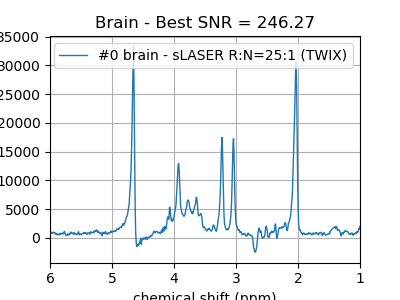

(DEBUG) MRSData2.display_spectrum_1d: displaying [#2 sLASER 10:2 TE=30ms (TWIX)]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!


<IPython.core.display.Javascript object>


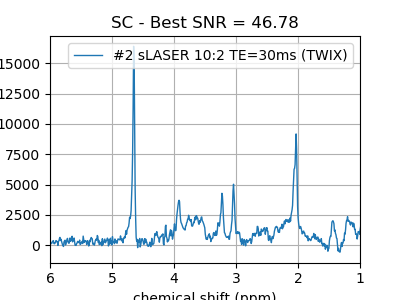

(DEBUG) MRSData2.display_spectrum_1d: displaying [#0 1st try (30-40Hz water LW)]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!


<IPython.core.display.Javascript object>


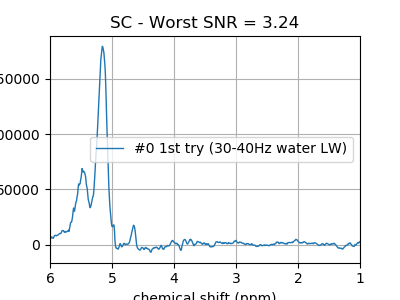

Text(0.5, 1.0, 'SC - Worst SNR = 3.24')

In [5]:
# finding best SNR spectrum in brain
i_snr_max = np.argmax(data_reco_with_brain["snr"])
pnk = data_reco_with_brain["patient name"][i_snr_max]
dk = data_reco_with_brain["dataset name"][i_snr_max]
s = pkl_data_dict[pnk][dk]["data"]
s._dt = 1 / 10000
s._f0 = 300
s.ppm0 = 4.7
s.display_spectrum_1d(1)
plt.title("Brain - Best SNR = %.2f" % data_reco_with_brain["snr"][i_snr_max])

# finding best SNR spectrum in sc
i_snr_max = np.argmax(data_reco["snr"])
pnk = data_reco["patient name"][i_snr_max]
dk = data_reco["dataset name"][i_snr_max]
s = pkl_data_dict[pnk][dk]["data"]
s._dt = 1 / 10000
s._f0 = 300
s.ppm0 = 4.7
s.display_spectrum_1d(2)
plt.title("SC - Best SNR = %.2f" % data_reco["snr"][i_snr_max])

# finding best SNR spectrum in sc
i_snr_min = np.argmin(data_reco["snr"])
pnk = data_reco["patient name"][i_snr_min]
dk = data_reco["dataset name"][i_snr_min]
s = pkl_data_dict[pnk][dk]["data"]
s._dt = 1 / 10000
s._f0 = 300
s.ppm0 = 4.7
s.display_spectrum_1d(3)
plt.title("SC - Worst SNR = %.2f" % data_reco["snr"][i_snr_min])


## Basic graph weight vs. height vs. BMI
to check patient consistency

<IPython.core.display.Javascript object>


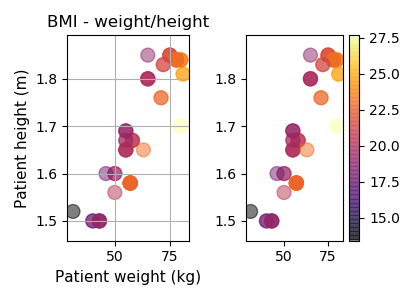

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f6294e32940>
(DEBUG) Using auto colorbar locator on colorbar
(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f6294e32940>
(DEBUG) Setting pcolormesh


In [6]:
cm = plt.cm.get_cmap('inferno')
fig, ax = plt.subplots(1, 2)
sc = ax[0].scatter(data_reco["weight"], data_reco["height"], c=data_reco["bmi"], s=100, alpha=0.5, cmap=cm)
ax[0].set_xlabel("Patient weight (kg)", fontsize=11)
ax[0].set_ylabel("Patient height (m)", fontsize=11)
ax[0].set_title("BMI - weight/height")
ax[0].grid(True)

ax[1].scatter(data_reco["weight"], data_reco["height"], c=data_reco["bmi"], s=100, alpha=0.5, cmap=cm)
ax[0].set_xlabel("Patient weight (kg)", fontsize=11)
ax[0].set_ylabel("Patient height (m)", fontsize=11)
ax[0].set_title("BMI - weight/height")
ax[0].grid(True)

plt.colorbar(sc)
fig.tight_layout()
plt.show()


## $B_1$ power (voltage) vs. BMI
reference RF voltage increases with BMI

<IPython.core.display.Javascript object>


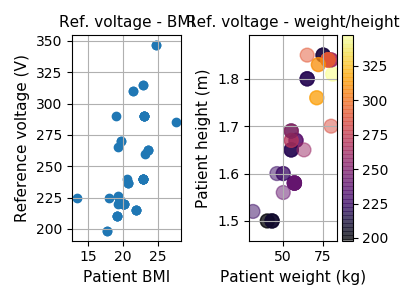

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f6295166f10>
(DEBUG) Using auto colorbar locator on colorbar
(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f6295166f10>
(DEBUG) Setting pcolormesh


In [7]:
cm = plt.cm.get_cmap('inferno')
fig, ax = plt.subplots(1, 2)
sc = ax[0].scatter(data_reco["bmi"], data_reco["vref"])
ax[0].set_xlabel("Patient BMI", fontsize=11)
ax[0].set_ylabel("Reference voltage (V)", fontsize=11)
ax[0].set_title("Ref. voltage - BMI", fontsize=11)
ax[0].grid(True)

sc = ax[1].scatter(data_reco["weight"], data_reco["height"], c=data_reco["vref"], s=100, alpha=0.5, cmap=cm)
ax[1].set_xlabel("Patient weight (kg)", fontsize=11)
ax[1].set_ylabel("Patient height (m)", fontsize=11)
ax[1].set_title("Ref. voltage - weight/height", fontsize=11)
ax[1].grid(True)

plt.colorbar(sc)
fig.tight_layout()
plt.show()

## SNR and LW vs. BMI
SNR is normalized: voxel size, number of averages (post-data-rejection), and voxel position in Y

<IPython.core.display.Javascript object>


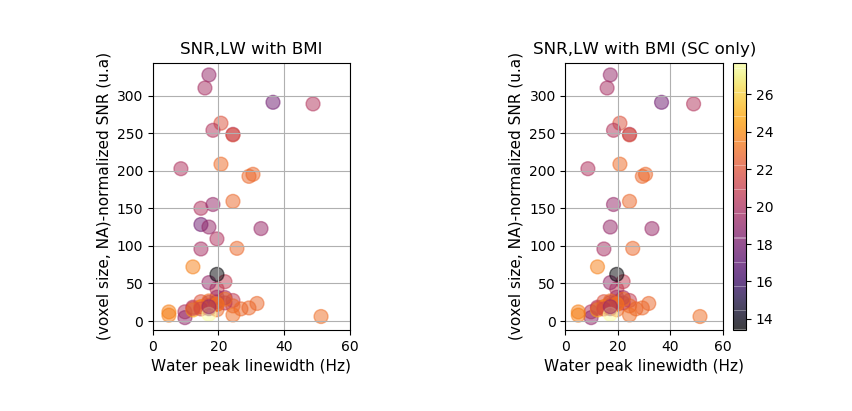

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f6295657be0>
(DEBUG) Using auto colorbar locator on colorbar
(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f6295657be0>
(DEBUG) Setting pcolormesh


In [8]:
# for each SNR measurement, normalize by voxel size and number of averages
# dicom data wil be rejected

# VOI normalization
mean_voxel_vol = np.mean(data_reco["voxel_volume"])
data_reco["snr norm."] = data_reco["snr"] / data_reco["voxel_volume"] * mean_voxel_vol
data_reco_with_brain["snr norm."] = data_reco_with_brain["snr"] / data_reco_with_brain["voxel_volume"] * mean_voxel_vol
data_reco["artefact_level norm."] = data_reco["artefact_level"] / data_reco["voxel_volume"] * mean_voxel_vol

# NA normalization
std_na = 128
data_reco["snr norm."] = data_reco["snr norm."] / np.sqrt(data_reco["na_post_rej"]) * np.sqrt(std_na)
data_reco_with_brain["snr norm."] = data_reco_with_brain["snr norm."] / np.sqrt(data_reco_with_brain["na_post_rej"]) * np.sqrt(std_na)
data_reco["artefact_level norm."] = data_reco["artefact_level norm."] / np.sqrt(data_reco["na_post_rej"]) * np.sqrt(std_na)

cm = plt.cm.get_cmap('inferno')
fig, ax = plt.subplots(1, 2)
sc0 = ax[0].scatter(data_reco_with_brain["lw"], data_reco_with_brain["snr norm."], c=data_reco_with_brain["bmi"], s=100, alpha=0.5, cmap=cm)
ax[0].set_xlabel("Water peak linewidth (Hz)", fontsize=11)
ax[0].set_ylabel("(voxel size, NA)-normalized SNR (u.a)", fontsize=11)
ax[0].set_title("SNR,LW with BMI")
ax[0].set_xlim([0, 60])
ax[0].grid(True)

sc1 = ax[1].scatter(data_reco["lw"], data_reco["snr norm."], c=data_reco["bmi"], s=100, alpha=0.5, cmap=cm)
ax[1].set_xlabel("Water peak linewidth (Hz)", fontsize=11)
ax[1].set_ylabel("(voxel size, NA)-normalized SNR (u.a)", fontsize=11)
ax[1].set_title("SNR,LW with BMI (SC only)")
ax[1].set_xlim([0, 60])
ax[1].grid(True)

plt.colorbar(sc1)
fig.tight_layout()
plt.show()

## Artefact around 5ppm
This artefact seems to increase when voxel size decreases in the X dimension. The sLASER sequence is a *semi-*LASER sequence, meaning that not all spatial dimensions are selected using adiabatic RF pulses (like in LASER). The X dimension is selected using a standard asymmetric RF sinc pulse whie Y and Z are selected using HSn Rf pulses.

I believe this artefact originates from badly localized signal in the X dimension because of the poor efficiency of the half sinc selection pulse in inhomogenous B1 situation (surface coil):
- This effect is increased when this bad pulse needs to select a small slice.
- Less clear but likely to happen, this effect is also increased when the VOI is far from the coil (Y position is high) and the B1 inhomogeneity gets even more crazy.
- Could be gradient non-linearities too?

(DEBUG) MRSData2.display_spectrum_1d: displaying [#2 sLASER 20:1 (DICOM)]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!


<IPython.core.display.Javascript object>


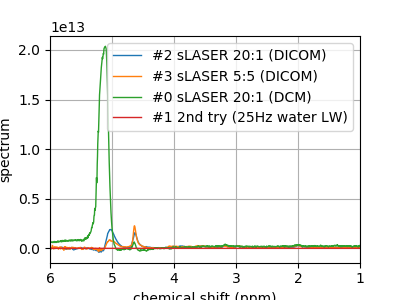

(DEBUG) MRSData2.display_spectrum_1d: displaying [#3 sLASER 5:5 (DICOM)]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(DEBUG) MRSData2.display_spectrum_1d: displaying [#0 sLASER 20:1 (DCM)]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(DEBUG) MRSData2.display_spectrum_1d: displaying [#1 2nd try (25Hz water LW)]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!


In [9]:
# find big artefact datasets
dataset_artefact_inds = np.where(data_reco["artefact_level norm."] > 500.0)[0]
for di in dataset_artefact_inds:
    pnk = data_reco["patient name"][di]
    dk = data_reco["dataset name"][di]
    s = pkl_data_dict[pnk][dk]["data"]
    s.display_spectrum_1d(100)

plt.show()


<IPython.core.display.Javascript object>


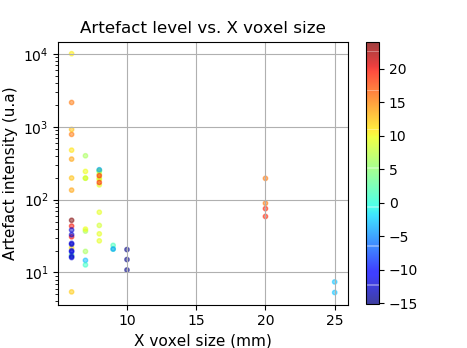

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f627fbf5df0>
(DEBUG) Using auto colorbar locator on colorbar
(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f627fbf5df0>
(DEBUG) Setting pcolormesh


In [96]:
cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc0 = ax.scatter(data_reco["voxel_size"][:, 0], data_reco["artefact_level norm."], c=data_reco["voxel_pos"][:, 1], s=10, alpha=0.5, cmap=cm)
ax.set_xlabel("X voxel size (mm)", fontsize=11)
ax.set_ylabel("Artefact intensity (u.a)", fontsize=11)
ax.set_yscale('log')
ax.set_title("Artefact level vs. X voxel size")
ax.grid(True)

plt.colorbar(sc0)